In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy import interp

import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, label_binarize, LabelBinarizer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.options.mode.chained_assignment = None

Корректируем датасет:  
1) корректировка используемого в модели значения капитализации и разницы логарифмов между раундами  
2) исключение раундов "без ответа"  
3) приведение дат к нужному формату

In [2]:
default_exit_value = 1 #"капитализация" мертвой компании в долларах

dataset = pd.read_csv('C:/Users/Barca/Desktop/GitHub/IPO_Analysis/model_ver_based_on_2019/wave_2/1_DataPreparation/funding_rounds_with_exits.csv')
DEMO_SET = pd.read_csv('C:/Users/Barca/Desktop/GitHub/IPO_Analysis/model_ver_based_on_2019/wave_2/1_DataPreparation/DEMO_SET.csv')
DEMO_SET2 = pd.read_csv('C:/Users/Barca/Desktop/GitHub/IPO_Analysis/model_ver_based_on_2019/wave_2/1_DataPreparation/DEMO_SET2.csv')
DEMO_SET_ALL = pd.read_csv('C:/Users/Barca/Desktop/GitHub/IPO_Analysis/model_ver_based_on_2019/wave_2/1_DataPreparation/DEMO_SET_ALL.csv')

ritter = pd.read_csv('nasdaq_wtd_mc_ritter_add.csv')
nasd = pd.read_excel('NASDAQ all v3.xlsx', sheet_name = 3)
unicorns = pd.read_excel('INDICES_all.xlsx', sheet_name = "new_tab")

nasd['Deflator_1M'] = nasd['Deflator'].shift(30)
nasd.loc[nasd['Deflator_1M'].isin([np.nan]), 'Deflator_1M'] = nasd['Deflator']
nasd['Deflator_3M'] = nasd['Deflator'].shift(90)
nasd.loc[nasd['Deflator_3M'].isin([np.nan]), 'Deflator_3M'] = nasd['Deflator']
nasd['Deflator_6M'] = nasd['Deflator'].shift(180)
nasd.loc[nasd['Deflator_6M'].isin([np.nan]), 'Deflator_6M'] = nasd['Deflator']
nasd['Deflator_9M'] = nasd['Deflator'].shift(270)
nasd.loc[nasd['Deflator_9M'].isin([np.nan]), 'Deflator_9M'] = nasd['Deflator']
nasd

,Date,Close,Change to 01-01-2009,Deflator,Deflator_1M,Deflator_3M,Deflator_6M,Deflator_9M
0,2000-01-01,4069.310059,2.580363,0.947930,0.947930,0.947930,0.947930,0.947930
1,2000-01-02,4069.310059,2.580363,0.947930,0.947930,0.947930,0.947930,0.947930
2,2000-01-03,4131.149902,2.619576,0.963012,0.963012,0.963012,0.963012,0.963012
3,2000-01-04,3901.689941,2.474075,0.905866,0.905866,0.905866,0.905866,0.905866
4,2000-01-05,3877.540039,2.458761,0.899658,0.899658,0.899658,0.899658,0.899658
...,...,...,...,...,...,...,...,...
6738,2018-06-13,7695.700195,4.879869,1.585118,1.547465,1.556922,1.481266,1.408300
6739,2018-06-14,7761.040039,4.921301,1.593573,1.539379,1.556955,1.481266,1.408300
6740,2018-06-15,7746.379883,4.912005,1.591682,1.545707,1.556955,1.481266,1.409256
6741,2018-06-16,7746.379883,4.912005,1.591682,1.543565,1.556955,1.489618,1.410290


In [3]:
unicorns['Date'] = pd.to_datetime(unicorns['Date'])
nasd = nasd.merge(unicorns[['Date', '1dd_unicorn_premium', '30dd_unicorn_premium', '60dd_unicorn_premium', '90dd_unicorn_premium']], how = 'left', on = 'Date')
nasd.fillna(method='ffill', inplace=True)
nasd

,Date,Close,Change to 01-01-2009,Deflator,Deflator_1M,Deflator_3M,Deflator_6M,Deflator_9M,1dd_unicorn_premium,30dd_unicorn_premium,60dd_unicorn_premium,90dd_unicorn_premium
0,2000-01-01,4069.310059,2.580363,0.947930,0.947930,0.947930,0.947930,0.947930,NaN,NaN,NaN,NaN
1,2000-01-02,4069.310059,2.580363,0.947930,0.947930,0.947930,0.947930,0.947930,NaN,NaN,NaN,NaN
2,2000-01-03,4131.149902,2.619576,0.963012,0.963012,0.963012,0.963012,0.963012,NaN,NaN,NaN,NaN
3,2000-01-04,3901.689941,2.474075,0.905866,0.905866,0.905866,0.905866,0.905866,NaN,NaN,NaN,NaN
4,2000-01-05,3877.540039,2.458761,0.899658,0.899658,0.899658,0.899658,0.899658,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
6738,2018-06-13,7695.700195,4.879869,1.585118,1.547465,1.556922,1.481266,1.408300,0.004179,0.029895,0.085699,0.050894
6739,2018-06-14,7761.040039,4.921301,1.593573,1.539379,1.556955,1.481266,1.408300,0.013379,0.042450,0.099078,0.061990
6740,2018-06-15,7746.379883,4.912005,1.591682,1.545707,1.556955,1.481266,1.409256,0.000086,0.048642,0.105946,0.062077
6741,2018-06-16,7746.379883,4.912005,1.591682,1.543565,1.556955,1.489618,1.410290,0.000086,0.048642,0.105946,0.062077


In [4]:
# ritter['Date'] = pd.to_datetime(ritter['Date'])
# nasd = nasd.merge(ritter[['Date', 'cumsum_add_ritter']], how = 'left', on = 'Date')
# nasd.fillna(method='ffill', inplace=True)
# nasd

In [5]:
dataset['announced_on'] = pd.to_datetime(dataset['announced_on'])
dataset = dataset.merge(nasd[['Date', 'Deflator', 'Deflator_1M', 'Deflator_3M', 'Deflator_6M', 'Deflator_9M', '1dd_unicorn_premium', '30dd_unicorn_premium', '60dd_unicorn_premium', '90dd_unicorn_premium']], how = 'left', left_on = 'announced_on', right_on = 'Date')
dataset

,funding_round_uuid,company_name,company_uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,exit_date,exit_type,price_usd,money_raised_usd,time_from_start,time_from_previous,industry,top_investor,other_investor,top_investor_count,other_investor_count,top_investor_sum,other_investor_sum,top_investor_rounds,other_investor_rounds,Date,Deflator,Deflator_1M,Deflator_3M,Deflator_6M,Deflator_9M,1dd_unicorn_premium,30dd_unicorn_premium,60dd_unicorn_premium,90dd_unicorn_premium
0,778db45f-e9d1-3f73-86f4-ae4cc79c48ff,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,seed,2010-01-01,500000.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2010-01-01,0.363862,0.326086,0.261374,0.130308,0.018645,0.007845,0.021845,0.027459,0.015225
1,fc2c2560-8bb0-90d1-b048-ee9cfc3f301d,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_a,2010-11-10,3000000.0,NaN,NaN,NaN,NaN,NaN,313.0,313.0,1.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0,2010-11-10,0.491773,0.420896,0.328481,0.397531,0.325399,0.013971,0.027335,0.074560,0.114060
2,d863a1b9-dda0-284e-3258-fa43a20d305c,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_b,2011-05-02,10000000.0,NaN,NaN,NaN,NaN,NaN,486.0,173.0,1.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0,2011-05-02,0.596704,0.570355,0.556490,0.476727,0.374344,-0.005799,-0.050548,0.009359,0.081986
3,4c9cb685-ec9a-92ed-64c0-062040d9573e,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_unknown,2011-08-24,1000000.0,NaN,NaN,NaN,NaN,NaN,600.0,114.0,1.0,0.0,1.0,3.0,2.0,6.0,2.0,3.0,1.0,2011-08-24,0.447739,0.589246,0.567957,0.567285,0.474477,-0.010875,-0.044482,-0.036443,-0.049591
4,1006ef75-d2f2-bac4-5737-dae2075cf616,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_c,2011-11-04,30000000.0,NaN,NaN,NaN,NaN,NaN,672.0,72.0,1.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0,2011-11-04,0.532566,0.444825,0.473628,0.583871,0.568342,-0.012203,0.026155,-0.016157,0.003177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7269,2067db69-a274-7914-0207-5fb1af6cc7ca,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,series_c,2012-10-23,46000000.0,NaN,2014-06-19,ipo,300000000.0,112000000.0,679.0,673.0,2.0,1.0,1.0,5.0,5.0,6.0,10.0,2.0,3.0,2012-10-23,0.639884,0.701325,0.593262,0.659798,0.579969,0.005853,-0.000554,0.077371,0.077260
7270,602347ee-2d81-7ad3-7f85-d68ea1fb8967,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,series_d,2014-03-05,55000000.0,NaN,2014-06-19,ipo,300000000.0,112000000.0,1177.0,498.0,2.0,1.0,1.0,5.0,5.0,6.0,10.0,2.0,3.0,2014-03-05,1.016463,0.929991,0.939009,0.841923,0.788386,0.015135,0.066531,0.197050,0.332969
7271,-,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,ipo,2014-06-19,112000000.0,300000000.0,2014-06-19,ipo,300000000.0,112000000.0,1283.0,106.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,2014-06-19,1.016775,0.954685,0.997659,0.956599,0.872786,-0.023655,0.074239,0.000570,-0.100373
7272,7792bf54-78d8-7159-329b-41e71e1c8f6b,Powermat Technologies,fff473e3-0f7d-b475-1da2-c9496721f49f,series_c,2011-10-06,80000000.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,1.0,2011-10-06,0.463472,0.450224,0.595212,0.567059,0.538882,0.006575,-0.032176,-0.016403,-0.060925


In [6]:
dataset['post_money_valuation_usd'] = pd.to_numeric(dataset['post_money_valuation_usd'], errors='coerce')
dataset.loc[dataset['post_money_valuation_usd'].isin([np.nan]), 'post_money_valuation_usd'] = 0
dataset['raised_amount_usd'] = pd.to_numeric(dataset['raised_amount_usd'], errors='coerce')
dataset.loc[dataset['raised_amount_usd'].isin([np.nan]), 'raised_amount_usd'] = 0
dataset['interpolated_money_valuation_usd'] = round(dataset['raised_amount_usd'] ** 1.1187, -6) #1.12751583465595
dataset.loc[(dataset['raised_amount_usd'] ** 1.1187 < 1000000) & (dataset['raised_amount_usd'] != 0), 'interpolated_money_valuation_usd'] = 1000000
dataset['interpolated_money_valuation_usd'] = pd.to_numeric(dataset['interpolated_money_valuation_usd'], errors='coerce')
dataset.loc[dataset['interpolated_money_valuation_usd'].isin([np.nan]), 'interpolated_money_valuation_usd'] = 0
dataset['valuation'] = dataset['interpolated_money_valuation_usd']
dataset.loc[dataset['valuation'] == 0, 'valuation'] = dataset['post_money_valuation_usd']
dataset.loc[dataset['investment_type'] == 'death', 'valuation'] = default_exit_value

dataset['total_sum_raised'] = dataset.groupby(['company_uuid'])['raised_amount_usd'].transform('cumsum')
dataset['total_sum_raised_before'] = dataset.groupby('company_uuid')['total_sum_raised'].shift(1)
dataset.loc[dataset['total_sum_raised_before'].isin([np.nan]), 'total_sum_raised_before'] = 0

dataset = dataset.replace('---', np.nan)
dataset.loc[(dataset['exit_type'].isin([np.nan])) | (dataset['exit_type'] == '0'), 'exit_type'] = 'dead'
dataset.loc[dataset['exit_type'] == 'dead', 'not_dead'] = 0
dataset.loc[dataset['exit_type'].isin(['sold', 'ipo']), 'not_dead'] = 1

dataset['announced_on'] = pd.to_datetime(dataset['announced_on'])
dataset['time_from_previous'] = pd.to_numeric(dataset['time_from_previous'], errors='coerce')
dataset.loc[dataset['time_from_previous'].isin([np.nan]), 'time_from_previous'] = 0
#добавляем скорость роста капитализации (исключаются все первые раунды в серии, необходимо 2+ раунда с ненулевой капитализацией)
dataset.loc[dataset['valuation'] != 0, 'val_log'] = np.log(dataset['valuation'])
dataset = dataset.loc[~dataset['val_log'].isin([np.nan])]
dataset['log_delta'] = dataset.groupby(['company_uuid'])['val_log'].diff()
dataset = dataset.loc[~dataset['log_delta'].isin([np.nan])]
dataset['val_rate'] = dataset['log_delta'] * (365 / dataset['time_from_previous'])
dataset.loc[dataset['total_sum_raised_before'] != 0, 'sum_raised_log'] = np.log(dataset['total_sum_raised_before'])
dataset = dataset.loc[~dataset['sum_raised_log'].isin([np.nan])]

#listColumns = ['top_quantil', 'is_PHD', 'is_Master', 'is_MBA']
#for i in listColumns:
#    dataset[i] = dataset[i].replace(np.nan, 0)

#for i in dataset.columns:
#    if i.startswith('EDU_'):
#        dataset[i] = pd.to_numeric(dataset[i], errors='coerce')
#        dataset.loc[dataset[i] != 0, i] = 1

y = dataset.loc[dataset['investment_type'].isin(['ipo', 'sold', 'death'])] #экзиты
dataset

C:\Users\Barca\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,funding_round_uuid,company_name,company_uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,exit_date,exit_type,price_usd,money_raised_usd,time_from_start,time_from_previous,industry,top_investor,other_investor,top_investor_count,other_investor_count,top_investor_sum,other_investor_sum,top_investor_rounds,other_investor_rounds,Date,Deflator,Deflator_1M,Deflator_3M,Deflator_6M,Deflator_9M,1dd_unicorn_premium,30dd_unicorn_premium,60dd_unicorn_premium,90dd_unicorn_premium,interpolated_money_valuation_usd,valuation,total_sum_raised,total_sum_raised_before,not_dead,val_log,log_delta,val_rate,sum_raised_log
1,fc2c2560-8bb0-90d1-b048-ee9cfc3f301d,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_a,2010-11-10,3000000.0,0.0,NaN,dead,NaN,NaN,313.0,313.0,1.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0,2010-11-10,0.491773,0.420896,0.328481,0.397531,0.325399,0.013971,0.027335,0.074560,0.114060,1.800000e+07,1.800000e+07,3500000.0,500000.0,0.0,16.705882,2.197225,2.562259,13.122363
2,d863a1b9-dda0-284e-3258-fa43a20d305c,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_b,2011-05-02,10000000.0,0.0,NaN,dead,NaN,NaN,486.0,173.0,1.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0,2011-05-02,0.596704,0.570355,0.556490,0.476727,0.374344,-0.005799,-0.050548,0.009359,0.081986,6.800000e+07,6.800000e+07,13500000.0,3500000.0,0.0,18.035018,1.329136,2.804246,15.068274
3,4c9cb685-ec9a-92ed-64c0-062040d9573e,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_unknown,2011-08-24,1000000.0,0.0,NaN,dead,NaN,NaN,600.0,114.0,1.0,0.0,1.0,3.0,2.0,6.0,2.0,3.0,1.0,2011-08-24,0.447739,0.589246,0.567957,0.567285,0.474477,-0.010875,-0.044482,-0.036443,-0.049591,5.000000e+06,5.000000e+06,14500000.0,13500000.0,0.0,15.424948,-2.610070,-8.356802,16.418200
4,1006ef75-d2f2-bac4-5737-dae2075cf616,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_c,2011-11-04,30000000.0,0.0,NaN,dead,NaN,NaN,672.0,72.0,1.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0,2011-11-04,0.532566,0.444825,0.473628,0.583871,0.568342,-0.012203,0.026155,-0.016157,0.003177,2.320000e+08,2.320000e+08,44500000.0,14500000.0,0.0,19.262248,3.837299,19.452976,16.489659
5,-,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,death,2015-08-01,0.0,0.0,NaN,dead,NaN,NaN,2038.0,1366.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2015-08-01,1.179227,1.155735,1.154972,1.087047,1.075639,0.002302,-0.004094,0.047311,0.078076,0.000000e+00,1.000000e+00,44500000.0,44500000.0,0.0,0.000000,-19.262248,-5.146940,17.611000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7268,e79c29e1-b5a7-db70-014d-36c2ba16338b,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,series_unknown,2010-12-20,792000.0,0.0,2014-06-19,ipo,300000000.0,112000000.0,6.0,6.0,2.0,0.0,1.0,5.0,5.0,6.0,10.0,2.0,3.0,2010-12-20,0.518850,0.467969,0.398595,0.357265,0.418846,-0.002680,-0.026385,-0.014426,-0.005902,4.000000e+06,4.000000e+06,1987972.0,1195972.0,1.0,15.201805,-0.405465,-24.665794,13.994470
7269,2067db69-a274-7914-0207-5fb1af6cc7ca,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,series_c,2012-10-23,46000000.0,0.0,2014-06-19,ipo,300000000.0,112000000.0,679.0,673.0,2.0,1.0,1.0,5.0,5.0,6.0,10.0,2.0,3.0,2012-10-23,0.639884,0.701325,0.593262,0.659798,0.579969,0.005853,-0.000554,0.077371,0.077260,3.740000e+08,3.740000e+08,47987972.0,1987972.0,1.0,19.739766,4.537961,2.461153,14.502626
7270,602347ee-2d81-7ad3-7f85-d68ea1fb8967,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,series_d,2014-03-05,55000000.0,0.0,2014-06-19,ipo,300000000.0,112000000.0,1177.0,498.0,2.0,1.0,1.0,5.0,5.0,6.0,10.0,2.0,3.0,2014-03-05,1.016463,0.929991,0.939009,0.841923,0.788386,0.015135,0.066531,0.197050,0.332969,4.560000e+08,4.560000e+08,102987972.0,47987972.0,1.0,19.938003,0.198237,0.145294,17.686461
7271,-,ZS Pharma,ffd3e2ec-f764-6135-4b41-9a861965223d,ipo,2014-06-19,112000000.0,300000000.0,2014-06-19,ipo,300000000.0,112000000.0,1283.0,106.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,2014-06-19,1.016775,0.954685,0.997659

Разбиваем на классы

In [7]:
y['val_rate'].describe([.5])

count    1182.000000
mean       -0.590828
std        14.691959
min       -21.510264
50%        -1.377733
max       343.241723
Name: val_rate, dtype: float64

In [8]:
y.groupby('investment_type').size()

investment_type
death    572
ipo      328
sold     282
dtype: int64

Все, что слева от медианного значения -1.008579 - нарвалы (с отрицательной скоростью роста привлеченных средств), справа - носороги (с положительной и околонулевой скоростью роста привлеченных средств)

In [9]:
dataset = dataset.loc[dataset['company_uuid'].isin(y['company_uuid'].values)]
dataset.loc[dataset.groupby('company_uuid')['val_rate'].shift(-1) <= -1.008579, 'class'] = 'narwhal'
dataset.loc[dataset.groupby('company_uuid')['val_rate'].shift(-1) > -1.008579, 'class'] = 'rhino'

additional = dataset.set_index('funding_round_uuid').groupby('company_uuid')['announced_on'].nlargest(2).reset_index()
dataset = dataset.loc[dataset['funding_round_uuid'].isin(additional['funding_round_uuid'].values)]
exits = dataset.copy()
dataset = dataset.loc[~dataset['investment_type'].isin(['ipo', 'sold', 'death'])] #преэкзиты
dataset

,funding_round_uuid,company_name,company_uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,exit_date,exit_type,price_usd,money_raised_usd,time_from_start,time_from_previous,industry,top_investor,other_investor,top_investor_count,other_investor_count,top_investor_sum,other_investor_sum,top_investor_rounds,other_investor_rounds,Date,Deflator,Deflator_1M,Deflator_3M,Deflator_6M,Deflator_9M,1dd_unicorn_premium,30dd_unicorn_premium,60dd_unicorn_premium,90dd_unicorn_premium,interpolated_money_valuation_usd,valuation,total_sum_raised,total_sum_raised_before,not_dead,val_log,log_delta,val_rate,sum_raised_log,class
4,1006ef75-d2f2-bac4-5737-dae2075cf616,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,series_c,2011-11-04,30000000.0,0.000000e+00,NaN,dead,NaN,NaN,672.0,72.0,1.0,1.0,0.0,3.0,2.0,6.0,2.0,3.0,1.0,2011-11-04,0.532566,0.444825,0.473628,0.583871,0.568342,-0.012203,0.026155,-0.016157,0.003177,2.320000e+08,2.320000e+08,44500000.0,14500000.0,0.0,19.262248,3.837299,19.452976,16.489659,narwhal
8,a9a651a1-7849-9329-e97a-8ce957637b71,CardiAQ Valve Technologies,009e8957-d102-c674-6c9c-98eb11ac8e32,series_b,2012-11-29,37300000.0,0.000000e+00,2015-07-10,sold,3.500000e+08,NaN,1296.0,1052.0,2.0,1.0,0.0,2.0,1.0,2.0,1.0,1.0,1.0,2012-11-29,0.647071,0.639044,0.665143,0.555141,0.635101,-0.021761,-0.006939,-0.003936,0.035151,2.950000e+08,2.950000e+08,44550000.0,7250000.0,1.0,19.502486,1.949306,0.676328,15.796512,rhino
15,951e44e7-27c6-b933-eb05-160c03705497,CellBiosciences,00e12273-bfa7-d0ac-25e2-c870ab22c474,series_f,2010-10-14,20000000.0,0.000000e+00,2014-06-17,sold,3.000000e+08,NaN,1747.0,297.0,2.0,1.0,1.0,6.0,5.0,14.0,10.0,4.0,3.0,2010-10-14,0.434559,0.372908,0.323346,0.453223,0.372130,0.002030,0.055065,0.123145,0.136792,1.470000e+08,1.470000e+08,85249999.0,65249999.0,1.0,18.805943,0.863298,1.060956,17.993737,rhino
25,fb9fe2de-8074-a467-9ed3-1bd9b2f5c66b,Verdezyne,0133e167-b2b5-b665-c76c-e2a65203263d,series_unknown,2014-03-28,48000000.0,0.000000e+00,NaN,dead,NaN,NaN,3200.0,1053.0,3.0,0.0,1.0,0.0,10.0,0.0,25.0,0.0,7.0,2014-03-28,0.968952,1.001223,0.969152,0.874601,0.778325,-0.014167,-0.111576,0.056912,0.114940,3.920000e+08,3.920000e+08,69853000.0,21853000.0,0.0,19.786772,1.876917,0.650593,16.899849,narwhal
39,6eca3823-4c26-250a-b7e5-c82666deadb2,Box,022bddcc-e01a-a6de-91e9-b93cfcc5a9ee,series_g,2014-07-01,150000000.0,2.400000e+09,2015-01-23,ipo,1.670000e+09,175000000.0,3225.0,208.0,1.0,0.0,1.0,11.0,13.0,29.0,15.0,9.0,5.0,2014-07-01,1.039303,0.989638,0.997582,0.965894,0.881495,-0.003428,0.070607,0.059757,-0.014798,1.402000e+09,1.402000e+09,558950000.0,408950000.0,1.0,21.061166,0.454434,0.797444,19.829103,rhino
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7241,4311ddf1-9db9-6dbb-e011-86df3f2161d8,Complete Genomics,fef181ac-2e1a-a041-8ac3-387a89571a7f,series_e,2010-08-19,39000000.0,0.000000e+00,2011-09-16,ipo,2.322000e+08,54000000.0,1605.0,360.0,2.0,1.0,1.0,4.0,3.0,8.0,7.0,2.0,3.0,2010-08-19,0.323300,0.343085,0.346028,0.352659,0.308081,-0.000478,0.027487,-0.006589,0.026323,3.110000e+08,3.110000e+08,128500000.0,89500000.0,1.0,19.555303,-0.157361,-0.159547,18.309749,rhino
7251,c9114172-7a01-695f-7c32-2807c58cd8a7,Juno Therapeutics,ff429091-2166-c3b5-409d-6e779fee09f5,series_b,2014-08-05,134000000.0,0.000000e+00,2014-12-19,ipo,1.675700e+09,264600000.0,245.0,103.0,2.0,1.0,1.0,2.0,2.0,4.0,4.0,3.0,3.0,2014-08-05,1.015285,1.045403,0.947527,0.944930,0.910352,0.000008,0.005672,0.069172,0.096265,1.235000e+09,1.235000e+09,310000000.0,176000000.0,1.0,20.934337,0.976789,3.461436,18.985995,rhino
7256,32ea83d9-9fe1-c480-c503-25eece562607,Aster Data Systems,ff65b5a2-e2f4-1557-b091-e93dfe88873e,series_c,2010-09-22,30000000.0,0.000000e+00,2011-03-03,sold,2.630000e+08,NaN,1786.0,574.0,1.0,1.0,1.0,5.0,4.0,11.0,7.0,4.0,4.0,2010-09-22,0.392276,0.314394,0.340801,0.417894,0.371125,-0.000004,0.080360,0.095039,0.080770,2.3200

In [10]:
#dataset.loc[dataset['90dd_unicorn_premium'].isin([np.nan])]

In [11]:
dataset.groupby('not_dead').size()

not_dead
0.0    383
1.0    550
dtype: int64

In [12]:
dataset.groupby('exit_type').size()

exit_type
dead    383
ipo     307
sold    243
dtype: int64

In [13]:
exits = exits.loc[(exits['investment_type'].isin(['ipo', 'sold', 'death'])) & (exits['company_uuid'].isin(dataset['company_uuid']))] #экзиты
exits.loc[exits['val_rate'] <= -1.008579, 'class'] = 'narwhal'
exits.loc[exits['val_rate'] > -1.008579, 'class'] = 'rhino'
exits

,funding_round_uuid,company_name,company_uuid,investment_type,announced_on,raised_amount_usd,post_money_valuation_usd,exit_date,exit_type,price_usd,money_raised_usd,time_from_start,time_from_previous,industry,top_investor,other_investor,top_investor_count,other_investor_count,top_investor_sum,other_investor_sum,top_investor_rounds,other_investor_rounds,Date,Deflator,Deflator_1M,Deflator_3M,Deflator_6M,Deflator_9M,1dd_unicorn_premium,30dd_unicorn_premium,60dd_unicorn_premium,90dd_unicorn_premium,interpolated_money_valuation_usd,valuation,total_sum_raised,total_sum_raised_before,not_dead,val_log,log_delta,val_rate,sum_raised_log,class
5,-,Lot18,003d89d4-47dc-e35a-ddf6-eda9940f3ba7,death,2015-08-01,0.0,0.000000e+00,NaN,dead,NaN,NaN,2038.0,1366.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2015-08-01,1.179227,1.155735,1.154972,1.087047,1.075639,0.002302,-0.004094,0.047311,0.078076,0.000000e+00,1.000000e+00,44500000.0,44500000.0,0.0,0.000000,-19.262248,-5.146940,17.611000,narwhal
9,-,CardiAQ Valve Technologies,009e8957-d102-c674-6c9c-98eb11ac8e32,sold,2015-07-10,0.0,3.500000e+08,2015-07-10,sold,3.500000e+08,NaN,2249.0,953.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2015-07-10,1.153434,1.169116,1.153090,1.092885,0.982788,0.018285,0.035443,0.081082,0.033767,0.000000e+00,3.500000e+08,44550000.0,44550000.0,1.0,19.673444,0.170958,0.065477,17.612123,rhino
16,-,CellBiosciences,00e12273-bfa7-d0ac-25e2-c870ab22c474,sold,2014-06-17,0.0,3.000000e+08,2014-06-17,sold,3.000000e+08,NaN,3089.0,1342.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,2014-06-17,1.011693,0.953146,1.004838,0.945181,0.872786,0.001378,0.093122,0.019521,-0.095545,0.000000e+00,3.000000e+08,85249999.0,85249999.0,1.0,19.519293,0.713350,0.194018,18.261099,rhino
26,-,Verdezyne,0133e167-b2b5-b665-c76c-e2a65203263d,death,2017-12-23,0.0,0.000000e+00,NaN,dead,NaN,NaN,4566.0,1366.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,2017-12-23,1.484630,1.471236,1.404952,1.376582,1.315187,-0.002696,-0.018877,-0.028795,-0.039472,0.000000e+00,1.000000e+00,69853000.0,69853000.0,0.0,0.000000,-19.786772,-5.287095,18.061904,narwhal
40,-,Box,022bddcc-e01a-a6de-91e9-b93cfcc5a9ee,ipo,2015-01-23,175000000.0,1.670000e+09,2015-01-23,ipo,1.670000e+09,175000000.0,3431.0,206.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,5.0,2015-01-23,1.104259,1.107530,1.044910,1.037262,0.949180,-0.001868,-0.043939,0.023486,-0.081170,1.665000e+09,1.665000e+09,733950000.0,558950000.0,1.0,21.233091,0.171925,0.304625,20.141571,rhino
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7242,-,Complete Genomics,fef181ac-2e1a-a041-8ac3-387a89571a7f,ipo,2011-09-16,54000000.0,2.322000e+08,2011-09-16,ipo,2.322000e+08,54000000.0,1998.0,393.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,2011-09-16,0.508512,0.465329,0.506287,0.516625,0.518850,-0.006546,0.007078,-0.027753,0.007368,4.470000e+08,4.470000e+08,182500000.0,128500000.0,1.0,19.918069,0.362766,0.336920,18.671439,rhino
7252,-,Juno Therapeutics,ff429091-2166-c3b5-409d-6e779fee09f5,ipo,2014-12-19,264600000.0,1.675700e+09,2014-12-19,ipo,1.675700e+09,264600000.0,381.0,136.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,2014-12-19,1.105834,1.086838,1.066110,1.018771,0.985805,0.004388,0.061045,-0.016185,-0.010768,2.645000e+09,2.645000e+09,574600000.0,310000000.0,1.0,21.695937,0.761600,2.044000,19.552083,rhino
7257,-,Aster Data Systems,ff65b5a2-e2f4-1557-b091-e93dfe88873e,sold,2011-03-03,0.0,2.630000e+08,2011-03-03,sold,2.630000e+08,NaN,1948.0,162.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,2011-03-03,0.573626,0.556490,0.496678,0.348138,0.341590,0.004589,0.072627,0.102021,0.067136,0.000000e+00,2.630000e+08,53000000.0,53000000.0,1.0,19.387665,0.125417,0.282575,17.785802,rhino
7266,-,Fisoc,ff7cac81-4ec2-eace-bcb4-faea16a8cf84,death,2017-12-27,0.0,0.000000e+00,NaN,dead,NaN,NaN,2757.0,1366.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,2017-12-27,1.481663,1.472860,1.409072,1.359350,1.321397,0.005425,-0.017224,-0.031254,-0.027536,0.000000e+00,1.00000

In [14]:
dataset.groupby('class').size()

class
narwhal    405
rhino      528
dtype: int64

Выравниваем количество сэмплов в классах

In [15]:
#np.random.seed(10)
#remove_n = 63
#
#df = dataset.loc[dataset['class'] == 'rhino']
#drop_indices = np.random.choice(df.index, remove_n, replace=False)
#dataset = dataset.drop(drop_indices)
#dataset.groupby('class').size()

Демо-датасеты для бэктестинга

In [16]:
DEMO_SET['announced_on'] = pd.to_datetime(DEMO_SET['announced_on'])
DEMO_SET = DEMO_SET.merge(nasd[['Date', 'Deflator', 'Deflator_1M', 'Deflator_3M', 'Deflator_6M', 'Deflator_9M', 'cumsum_add_ritter']], how = 'left', left_on = 'announced_on', right_on = 'Date')

DEMO_SET['post_money_valuation_usd'] = pd.to_numeric(DEMO_SET['post_money_valuation_usd'], errors='coerce')
DEMO_SET.loc[DEMO_SET['post_money_valuation_usd'].isin([np.nan]), 'post_money_valuation_usd'] = 0
DEMO_SET['raised_amount_usd'] = pd.to_numeric(DEMO_SET['raised_amount_usd'], errors='coerce')
DEMO_SET.loc[DEMO_SET['raised_amount_usd'].isin([np.nan]), 'raised_amount_usd'] = 0
DEMO_SET['interpolated_money_valuation_usd'] = round(DEMO_SET['raised_amount_usd'] ** 1.1187, -6) #1.12751583465595
DEMO_SET.loc[(DEMO_SET['raised_amount_usd'] ** 1.1187 < 1000000) & (DEMO_SET['raised_amount_usd'] != 0), 'interpolated_money_valuation_usd'] = 1000000
DEMO_SET['interpolated_money_valuation_usd'] = pd.to_numeric(DEMO_SET['interpolated_money_valuation_usd'], errors='coerce')
DEMO_SET.loc[DEMO_SET['interpolated_money_valuation_usd'].isin([np.nan]), 'interpolated_money_valuation_usd'] = 0
DEMO_SET['valuation'] = DEMO_SET['interpolated_money_valuation_usd']
DEMO_SET.loc[DEMO_SET['valuation'] == 0, 'valuation'] = DEMO_SET['post_money_valuation_usd']
DEMO_SET.loc[DEMO_SET['investment_type'] == 'death', 'valuation'] = default_exit_value

DEMO_SET['total_sum_raised'] = DEMO_SET.groupby(['company_uuid'])['raised_amount_usd'].transform('cumsum')
DEMO_SET['total_sum_raised_before'] = DEMO_SET.groupby('company_uuid')['total_sum_raised'].shift(1)
DEMO_SET.loc[DEMO_SET['total_sum_raised_before'].isin([np.nan]), 'total_sum_raised_before'] = 0

DEMO_SET = DEMO_SET.replace('---', np.nan)
DEMO_SET['announced_on'] = pd.to_datetime(DEMO_SET['announced_on'])
DEMO_SET['time_from_previous'] = pd.to_numeric(DEMO_SET['time_from_previous'], errors='coerce')
DEMO_SET.loc[DEMO_SET['time_from_previous'].isin([np.nan]), 'time_from_previous'] = 0
#добавляем скорость роста капитализации (исключаются все первые раунды в серии, необходимо 2+ раунда с ненулевой капитализацией)
DEMO_SET.loc[DEMO_SET['valuation'] != 0, 'val_log'] = np.log(DEMO_SET['valuation'])
DEMO_SET = DEMO_SET.loc[~DEMO_SET['val_log'].isin([np.nan])]
DEMO_SET['log_delta'] = DEMO_SET.groupby(['company_uuid'])['val_log'].diff()
DEMO_SET = DEMO_SET.loc[~DEMO_SET['log_delta'].isin([np.nan])]
DEMO_SET['log_delta'] = pd.to_numeric(DEMO_SET['log_delta'], errors='coerce')
DEMO_SET['val_rate'] = DEMO_SET['log_delta'] * (365 / DEMO_SET['time_from_previous'])
DEMO_SET.loc[DEMO_SET['total_sum_raised_before'] != 0, 'sum_raised_log'] = np.log(DEMO_SET['total_sum_raised_before'])
DEMO_SET = DEMO_SET.loc[~DEMO_SET['sum_raised_log'].isin([np.nan])]

DEMO_SET = DEMO_SET.loc[DEMO_SET.groupby(['company_uuid'])['announced_on'].idxmax()]
DEMO_SET

KeyError: "['cumsum_add_ritter'] not in index"

In [17]:
DEMO_SET2['announced_on'] = pd.to_datetime(DEMO_SET2['announced_on'])
DEMO_SET2 = DEMO_SET2.merge(nasd[['Date', 'Deflator', 'Deflator_1M', 'Deflator_3M', 'Deflator_6M', 'Deflator_9M', 'cumsum_add_ritter']], how = 'left', left_on = 'announced_on', right_on = 'Date')

DEMO_SET2['post_money_valuation_usd'] = pd.to_numeric(DEMO_SET2['post_money_valuation_usd'], errors='coerce')
DEMO_SET2.loc[DEMO_SET2['post_money_valuation_usd'].isin([np.nan]), 'post_money_valuation_usd'] = 0
DEMO_SET2['raised_amount_usd'] = pd.to_numeric(DEMO_SET2['raised_amount_usd'], errors='coerce')
DEMO_SET2.loc[DEMO_SET2['raised_amount_usd'].isin([np.nan]), 'raised_amount_usd'] = 0
DEMO_SET2['interpolated_money_valuation_usd'] = round(DEMO_SET2['raised_amount_usd'] ** 1.1187, -6) #1.12751583465595
DEMO_SET2.loc[(DEMO_SET2['raised_amount_usd'] ** 1.1187 < 1000000) & (DEMO_SET2['raised_amount_usd'] != 0), 'interpolated_money_valuation_usd'] = 1000000
DEMO_SET2['interpolated_money_valuation_usd'] = pd.to_numeric(DEMO_SET2['interpolated_money_valuation_usd'], errors='coerce')
DEMO_SET2.loc[DEMO_SET2['interpolated_money_valuation_usd'].isin([np.nan]), 'interpolated_money_valuation_usd'] = 0
DEMO_SET2['valuation'] = DEMO_SET2['interpolated_money_valuation_usd']
DEMO_SET2.loc[DEMO_SET2['valuation'] == 0, 'valuation'] = DEMO_SET2['post_money_valuation_usd']
DEMO_SET2.loc[DEMO_SET2['investment_type'] == 'death', 'valuation'] = default_exit_value

DEMO_SET2['total_sum_raised'] = DEMO_SET2.groupby(['company_uuid'])['raised_amount_usd'].transform('cumsum')
DEMO_SET2['total_sum_raised_before'] = DEMO_SET2.groupby('company_uuid')['total_sum_raised'].shift(1)
DEMO_SET2.loc[DEMO_SET2['total_sum_raised_before'].isin([np.nan]), 'total_sum_raised_before'] = 0

DEMO_SET2 = DEMO_SET2.replace('---', np.nan)
DEMO_SET2['announced_on'] = pd.to_datetime(DEMO_SET2['announced_on'])
DEMO_SET2['time_from_previous'] = pd.to_numeric(DEMO_SET2['time_from_previous'], errors='coerce')
DEMO_SET2.loc[DEMO_SET2['time_from_previous'].isin([np.nan]), 'time_from_previous'] = 0
#добавляем скорость роста капитализации (исключаются все первые раунды в серии, необходимо 2+ раунда с ненулевой капитализацией)
DEMO_SET2.loc[DEMO_SET2['valuation'] != 0, 'val_log'] = np.log(DEMO_SET2['valuation'])
DEMO_SET2 = DEMO_SET2.loc[~DEMO_SET2['val_log'].isin([np.nan])]
DEMO_SET2['log_delta'] = DEMO_SET2.groupby(['company_uuid'])['val_log'].diff()
DEMO_SET2 = DEMO_SET2.loc[~DEMO_SET2['log_delta'].isin([np.nan])]
DEMO_SET2['log_delta'] = pd.to_numeric(DEMO_SET2['log_delta'], errors='coerce')
DEMO_SET2['val_rate'] = DEMO_SET2['log_delta'] * (365 / DEMO_SET2['time_from_previous'])
DEMO_SET2.loc[DEMO_SET2['total_sum_raised_before'] != 0, 'sum_raised_log'] = np.log(DEMO_SET2['total_sum_raised_before'])
DEMO_SET2 = DEMO_SET2.loc[~DEMO_SET2['sum_raised_log'].isin([np.nan])]

DEMO_SET2 = DEMO_SET2.loc[DEMO_SET2.groupby(['company_uuid'])['announced_on'].idxmax()]
DEMO_SET2

KeyError: "['cumsum_add_ritter'] not in index"

In [18]:
DEMO_SET_ALL['announced_on'] = pd.to_datetime(DEMO_SET_ALL['announced_on'])
DEMO_SET_ALL = DEMO_SET_ALL.merge(nasd[['Date', 'Deflator', 'Deflator_1M', 'Deflator_3M', 'Deflator_6M', 'Deflator_9M', 'cumsum_add_ritter']], how = 'left', left_on = 'announced_on', right_on = 'Date')

DEMO_SET_ALL['post_money_valuation_usd'] = pd.to_numeric(DEMO_SET_ALL['post_money_valuation_usd'], errors='coerce')
DEMO_SET_ALL.loc[DEMO_SET_ALL['post_money_valuation_usd'].isin([np.nan]), 'post_money_valuation_usd'] = 0
DEMO_SET_ALL['raised_amount_usd'] = pd.to_numeric(DEMO_SET_ALL['raised_amount_usd'], errors='coerce')
DEMO_SET_ALL.loc[DEMO_SET_ALL['raised_amount_usd'].isin([np.nan]), 'raised_amount_usd'] = 0
DEMO_SET_ALL['interpolated_money_valuation_usd'] = round(DEMO_SET_ALL['raised_amount_usd'] ** 1.1187, -6) #1.12751583465595
DEMO_SET_ALL.loc[(DEMO_SET_ALL['raised_amount_usd'] ** 1.1187 < 1000000) & (DEMO_SET_ALL['raised_amount_usd'] != 0), 'interpolated_money_valuation_usd'] = 1000000
DEMO_SET_ALL['interpolated_money_valuation_usd'] = pd.to_numeric(DEMO_SET_ALL['interpolated_money_valuation_usd'], errors='coerce')
DEMO_SET_ALL.loc[DEMO_SET_ALL['interpolated_money_valuation_usd'].isin([np.nan]), 'interpolated_money_valuation_usd'] = 0
DEMO_SET_ALL['valuation'] = DEMO_SET_ALL['interpolated_money_valuation_usd']
DEMO_SET_ALL.loc[DEMO_SET_ALL['valuation'] == 0, 'valuation'] = DEMO_SET_ALL['post_money_valuation_usd']
DEMO_SET_ALL.loc[DEMO_SET_ALL['investment_type'] == 'death', 'valuation'] = default_exit_value

DEMO_SET_ALL['total_sum_raised'] = DEMO_SET_ALL.groupby(['company_uuid'])['raised_amount_usd'].transform('cumsum')
DEMO_SET_ALL['total_sum_raised_before'] = DEMO_SET_ALL.groupby('company_uuid')['total_sum_raised'].shift(1)
DEMO_SET_ALL.loc[DEMO_SET_ALL['total_sum_raised_before'].isin([np.nan]), 'total_sum_raised_before'] = 0

DEMO_SET_ALL = DEMO_SET_ALL.replace('---', np.nan)
DEMO_SET_ALL['announced_on'] = pd.to_datetime(DEMO_SET_ALL['announced_on'])
DEMO_SET_ALL['time_from_previous'] = pd.to_numeric(DEMO_SET_ALL['time_from_previous'], errors='coerce')
DEMO_SET_ALL.loc[DEMO_SET_ALL['time_from_previous'].isin([np.nan]), 'time_from_previous'] = 0
#добавляем скорость роста капитализации (исключаются все первые раунды в серии, необходимо 2+ раунда с ненулевой капитализацией)
DEMO_SET_ALL.loc[DEMO_SET_ALL['valuation'] != 0, 'val_log'] = np.log(DEMO_SET_ALL['valuation'])
DEMO_SET_ALL = DEMO_SET_ALL.loc[~DEMO_SET_ALL['val_log'].isin([np.nan])]
DEMO_SET_ALL['log_delta'] = DEMO_SET_ALL.groupby(['company_uuid'])['val_log'].diff()
DEMO_SET_ALL = DEMO_SET_ALL.loc[~DEMO_SET_ALL['log_delta'].isin([np.nan])]
DEMO_SET_ALL['log_delta'] = pd.to_numeric(DEMO_SET_ALL['log_delta'], errors='coerce')
DEMO_SET_ALL['val_rate'] = DEMO_SET_ALL['log_delta'] * (365 / DEMO_SET_ALL['time_from_previous'])
DEMO_SET_ALL.loc[DEMO_SET_ALL['total_sum_raised_before'] != 0, 'sum_raised_log'] = np.log(DEMO_SET_ALL['total_sum_raised_before'])
DEMO_SET_ALL = DEMO_SET_ALL.loc[~DEMO_SET_ALL['sum_raised_log'].isin([np.nan])]

DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL.groupby(['company_uuid'])['announced_on'].idxmax()]
DEMO_SET_ALL

KeyError: "['cumsum_add_ritter'] not in index"

In [19]:
# DEMO_SET_ALL['raised_amount_usd'] = pd.to_numeric(DEMO_SET_ALL['raised_amount_usd'], errors='coerce')
# DEMO_SET_ALL.loc[DEMO_SET_ALL['raised_amount_usd'].isin([np.nan]), 'raised_amount_usd'] = 0
# DEMO_SET_ALL['interpolated_money_valuation_usd'] = round(DEMO_SET_ALL['raised_amount_usd'] ** 1.1187, -6) #1.12751583465595
# DEMO_SET_ALL.loc[(DEMO_SET_ALL['raised_amount_usd'] ** 1.1187 < 1000000) & (DEMO_SET_ALL['raised_amount_usd'] != 0), 'interpolated_money_valuation_usd'] = 1000000
# DEMO_SET_ALL['interpolated_money_valuation_usd'] = pd.to_numeric(DEMO_SET_ALL['interpolated_money_valuation_usd'], errors='coerce')
# DEMO_SET_ALL.loc[DEMO_SET_ALL['interpolated_money_valuation_usd'].isin([np.nan]), 'interpolated_money_valuation_usd'] = 0
# DEMO_SET_ALL['post_money_valuation_usd'] = pd.to_numeric(DEMO_SET_ALL['post_money_valuation_usd'], errors='coerce')
# DEMO_SET_ALL.loc[DEMO_SET_ALL['post_money_valuation_usd'].isin([np.nan]), 'post_money_valuation_usd'] = 0

# DEMO_SET_ALL['total_sum_raised'] = DEMO_SET_ALL.groupby(['company_uuid'])['raised_amount_usd'].transform('cumsum')
# DEMO_SET_ALL['total_sum_raised_before'] = DEMO_SET_ALL.groupby('company_uuid')['total_sum_raised'].shift(1)

# DEMO_SET_ALL['valuation'] = DEMO_SET_ALL['interpolated_money_valuation_usd']
# DEMO_SET_ALL.loc[DEMO_SET_ALL['valuation'] == 0, 'valuation'] = DEMO_SET_ALL['post_money_valuation_usd']
# DEMO_SET_ALL.loc[DEMO_SET_ALL['investment_type'] == 'death', 'valuation'] = default_exit_value

# DEMO_SET_ALL.loc[DEMO_SET_ALL['valuation'] != 0, 'val_log'] = np.log(DEMO_SET_ALL['valuation'])
# DEMO_SET_ALL = DEMO_SET_ALL.loc[~DEMO_SET_ALL['val_log'].isin([np.nan])]
# DEMO_SET_ALL['log_delta'] = DEMO_SET_ALL.groupby(['company_uuid'])['val_log'].diff()
# DEMO_SET_ALL = DEMO_SET_ALL.loc[~DEMO_SET_ALL['log_delta'].isin([np.nan])]

# DEMO_SET_ALL = DEMO_SET_ALL.replace('---', np.nan)
# DEMO_SET_ALL['announced_on'] = pd.to_datetime(DEMO_SET_ALL['announced_on'])
# DEMO_SET_ALL['log_delta'] = pd.to_numeric(DEMO_SET_ALL['log_delta'], errors='coerce')
# DEMO_SET_ALL['time_from_previous'] = pd.to_numeric(DEMO_SET_ALL['time_from_previous'], errors='coerce')
# DEMO_SET_ALL['val_rate'] = DEMO_SET_ALL['log_delta'] * (365 / DEMO_SET_ALL['time_from_previous'])

# DEMO_SET_ALL = DEMO_SET_ALL.loc[DEMO_SET_ALL.groupby(['company_uuid'])['announced_on'].idxmax()]
# DEMO_SET_ALL = DEMO_SET_ALL.sort_values(by=['announced_on'])
# DEMO_SET_ALL.to_csv('DEMO_SET_ALL_sorted.csv', encoding = 'utf-8-sig')
# DEMO_SET_ALL

### Матрица корреляций и графики взаимной зависимости между признаками

In [20]:
test_tab = dataset.drop(columns=['exit_type', 'class', 'funding_round_uuid', 'company_name', 'company_uuid', 'announced_on', 'raised_amount_usd', 'post_money_valuation_usd', 'interpolated_money_valuation_usd', 'exit_date', 'price_usd', 'money_raised_usd', 'total_sum_raised', 'log_delta', 'investment_type', 'Date']) #'exit_type', 'not_dead', 'class'
#test_tab.loc[test_tab['exit_type'] == 'sold', 'exit_type'] = -1
#test_tab.loc[test_tab['exit_type'] == 'dead', 'exit_type'] = 0
#test_tab.loc[test_tab['exit_type'] == 'ipo', 'exit_type'] = 1
#test_tab.loc[test_tab['class'] == 'narwhal', 'class'] = 0
#test_tab.loc[test_tab['class'] == 'rhino', 'class'] = 1
test_tab = test_tab.drop(columns=['Deflator_1M', 'Deflator_3M', 'Deflator_6M', 'Deflator_9M', 'total_sum_raised_before', 'valuation', 'top_investor', 'other_investor'])
test_tab = test_tab.astype('float')
test_tab.corr()

,time_from_start,time_from_previous,industry,top_investor_count,other_investor_count,top_investor_sum,other_investor_sum,top_investor_rounds,other_investor_rounds,Deflator,1dd_unicorn_premium,30dd_unicorn_premium,60dd_unicorn_premium,90dd_unicorn_premium,not_dead,val_log,val_rate,sum_raised_log
time_from_start,1.000000,0.321992,-0.086264,0.091202,0.170026,0.215841,0.256931,0.369792,0.462947,0.112296,0.002319,0.041695,0.032534,0.041226,0.067405,-0.034678,-0.059807,0.360158
time_from_previous,0.321992,1.000000,-0.015272,-0.097575,-0.037640,-0.119779,-0.044869,-0.141445,-0.084227,-0.000884,-0.019930,-0.018270,-0.003635,0.003947,-0.044214,0.106125,-0.024153,-0.224182
industry,-0.086264,-0.015272,1.000000,-0.164563,-0.074557,-0.176234,-0.091477,-0.164255,-0.110595,-0.090911,0.026133,0.026972,0.064061,0.068155,-0.117963,-0.058362,-0.029636,0.009142
top_investor_count,0.091202,-0.097575,-0.164563,1.000000,0.469924,0.879218,0.405145,0.645528,0.301860,0.148677,0.021482,-0.026979,-0.033031,-0.007041,0.301486,0.358346,-0.011748,0.279461
other_investor_count,0.170026,-0.037640,-0.074557,0.469924,1.000000,0.394509,0.920788,0.349341,0.615581,0.149938,-0.002427,0.018064,0.022362,0.010594,0.181972,0.308331,0.006164,0.208430
top_investor_sum,0.215841,-0.119779,-0.176234,0.879218,0.394509,1.000000,0.395718,0.774589,0.362865,0.137393,0.024730,-0.009347,-0.025389,0.011140,0.254302,0.234967,-0.017135,0.334586
other_investor_sum,0.256931,-0.044869,-0.091477,0.405145,0.920788,0.395718,1.000000,0.384772,0.716611,0.115119,0.019813,0.042979,0.042248,0.026587,0.171106,0.252896,-0.003448,0.249016
top_investor_rounds,0.369792,-0.141445,-0.164255,0.645528,0.349341,0.774589,0.384772,1.000000,0.514114,0.097596,0.005037,0.025848,-0.007484,0.001658,0.275145,0.112025,-0.071149,0.469892
other_investor_rounds,0.462947,-0.084227,-0.110595,0.301860,0.615581,0.362865,0.716611,0.514114,1.000000,0.109816,0.044911,0.075744,0.046577,0.033740,0.152930,0.130454,-0.031248,0.411569
Deflator,0.112296,-0.000884,-0.090911,0.148677,0.149938,0.137393,0.115119,0.097596,0.109816,1.000000,0.010412,-0.054727,-0.060025,-0.049056,0.204162,0.109624,-0.005357,0.041859


<AxesSubplot:>

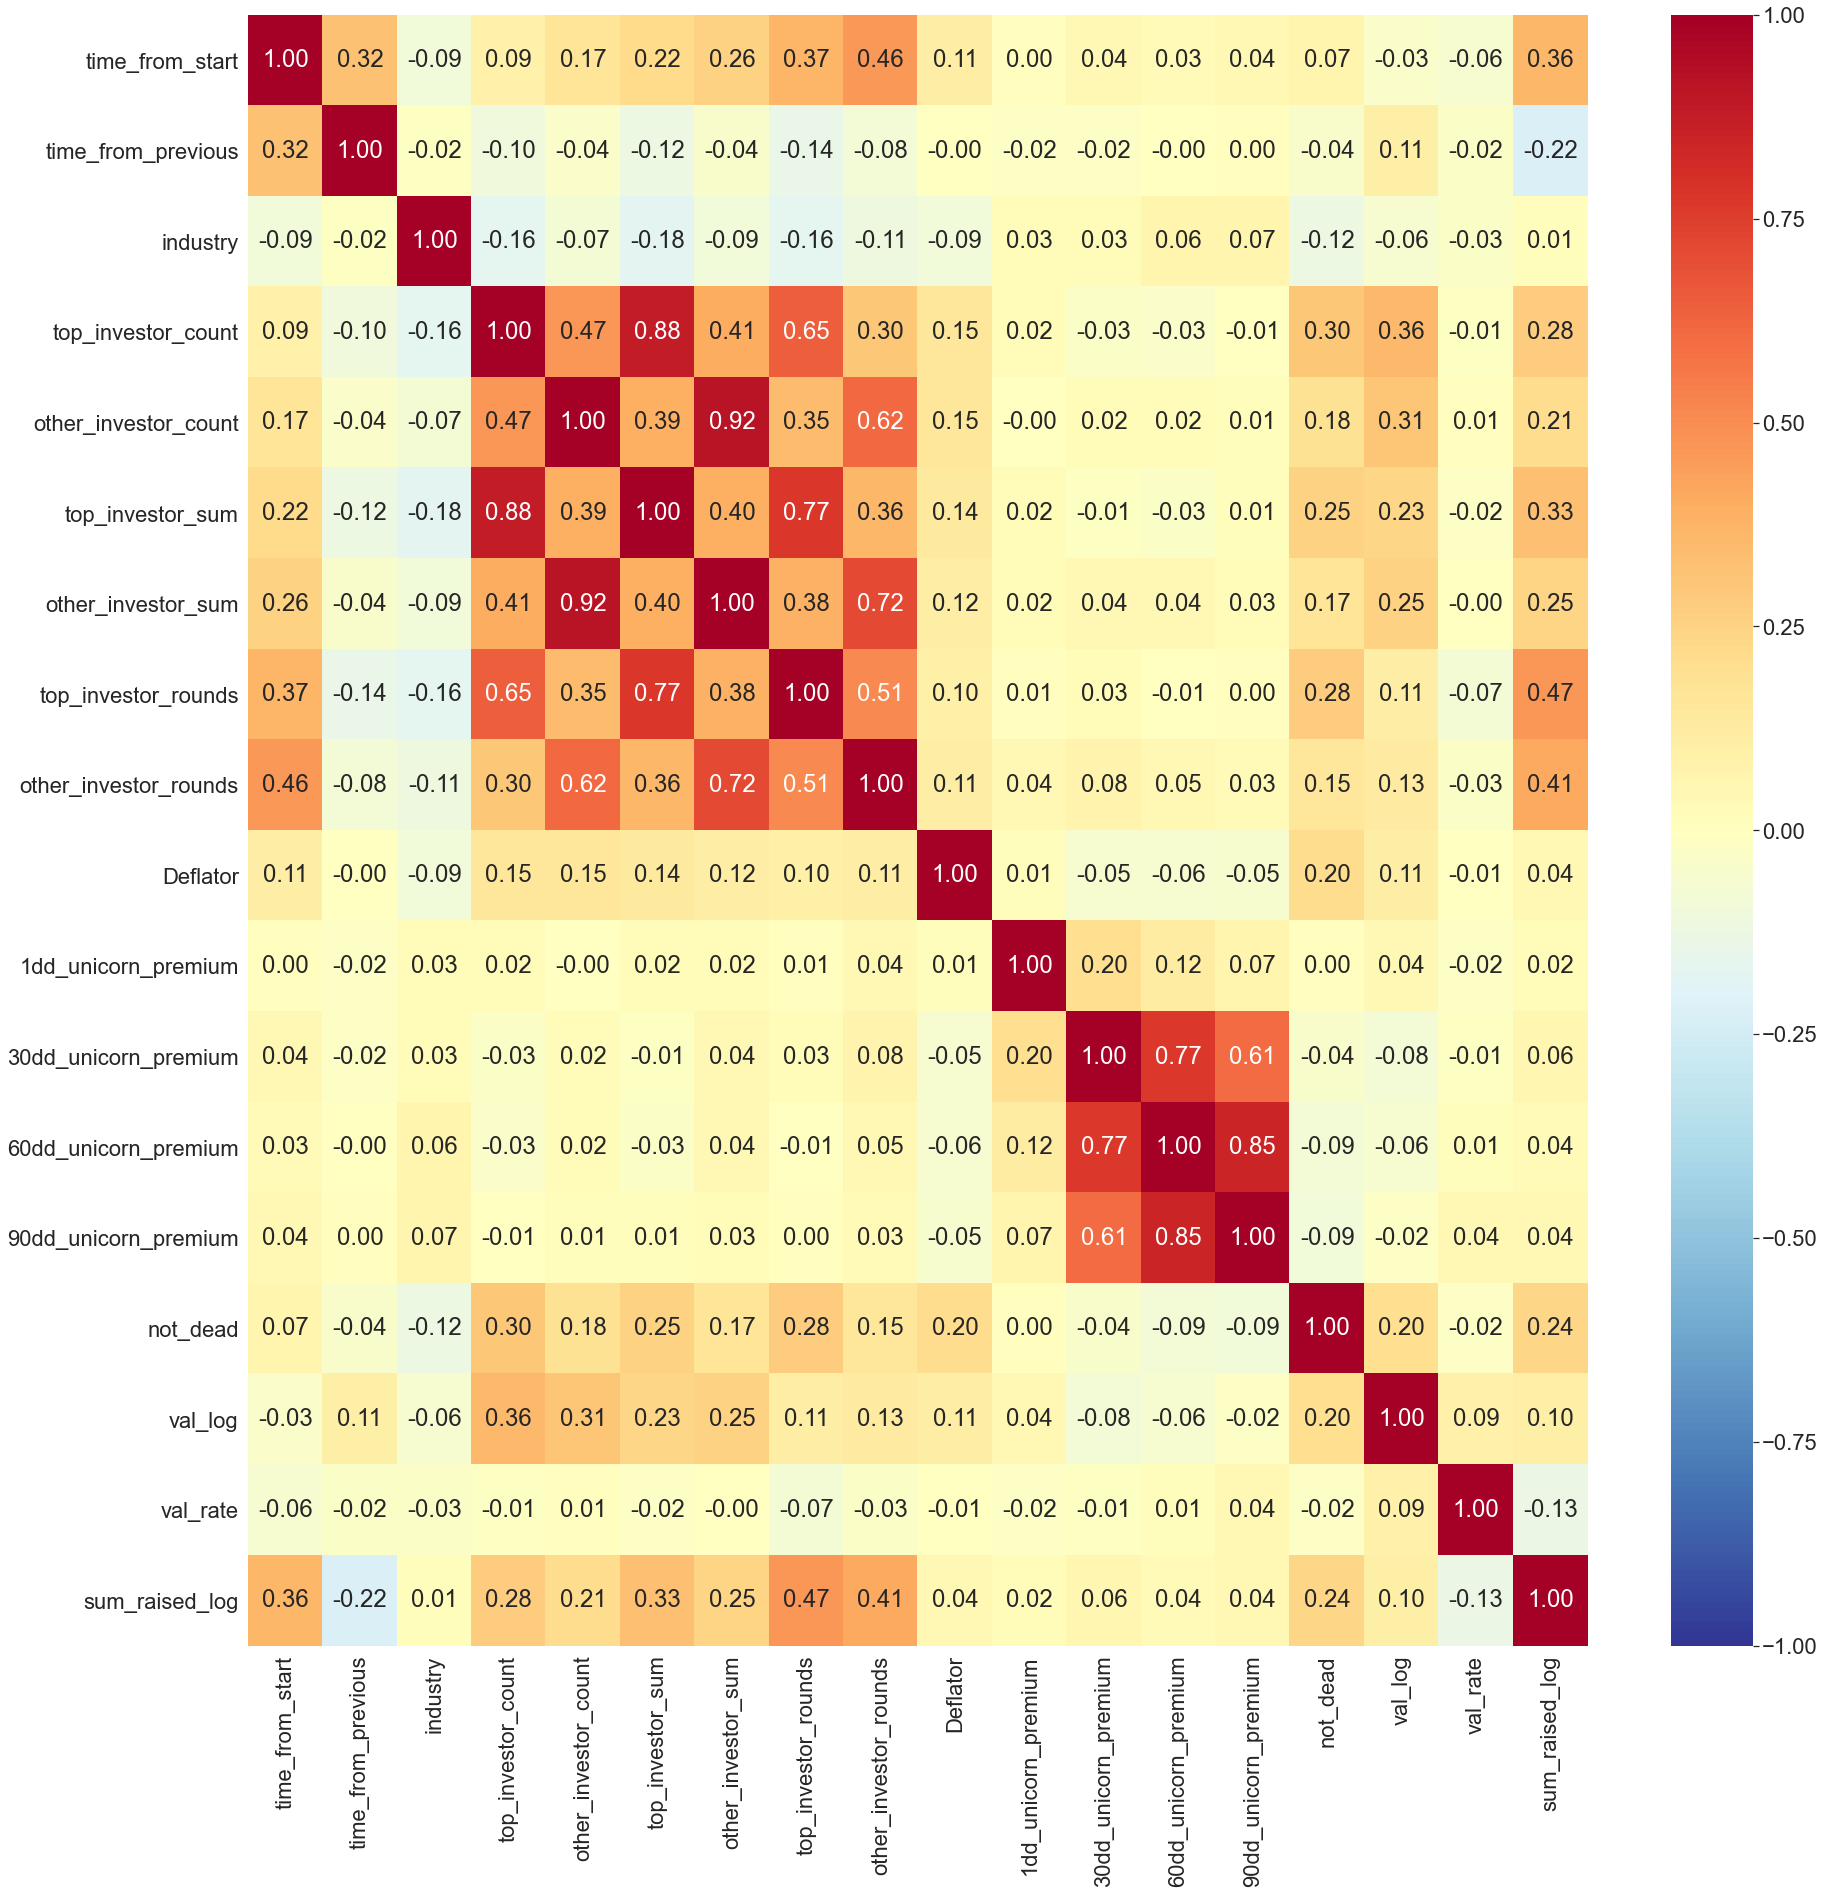

In [21]:
plt.figure(figsize=(30, 30))
sns.set(font_scale=2)
sns.heatmap(test_tab.corr(), annot=True, cmap='RdYlBu_r', vmin=-1, vmax=1, fmt='.2f')
#plt.savefig("heatmap.png")

In [22]:
# dates = dataset['announced_on'].dt.strftime('%Y-%m-%d')
# dates = dates.str[:4]
# dates = dates.values.astype(int)
# dates = dates.ravel()
# dates

In [23]:
# import itertools
# pair_ids = list(itertools.combinations(range(len(test_tab.columns)), 2))
# for pair in pair_ids:
#     plt.figure(figsize=(10, 10))
#     plt.scatter(test_tab.iloc[:, pair[0]], test_tab.iloc[:, pair[1]], c=dates, cmap='RdYlBu_r')
#     plt.xlabel(test_tab.iloc[:, pair[0]].name)
#     plt.ylabel(test_tab.iloc[:, pair[1]].name)
#     plt.grid()
#     plt.savefig("Plots/" + test_tab.iloc[:, pair[0]].name + " VS " + test_tab.iloc[:, pair[1]].name + ".png")

In [24]:
# classes = dataset.copy()
# classes.loc[classes['class'] == 'narwhal', 'class'] = 0
# classes.loc[classes['class'] == 'rhino', 'class'] = 1
# classes = classes['class'].values
# classes

In [25]:
# plt.figure(figsize=(10, 10))
# scatter = plt.scatter(dataset['time_from_previous'], dataset['log_delta'], c=classes, cmap='RdYlBu_r')
# plt.xlabel('time_from_previous')
# plt.ylabel('log_delta')
# plt.grid()
# plt.legend(handles=scatter.legend_elements()[0], labels=['narwhal', 'rhino'])
# plt.savefig("pre_exit_time_from_previous VS log_delta.png")

In [26]:
# plt.figure(figsize=(10, 10))
# scatter = plt.scatter(exits['time_from_previous'], exits['log_delta'], c=classes, cmap='RdYlBu_r')
# plt.xlabel('time_from_previous')
# plt.ylabel('log_delta')
# plt.grid()
# plt.legend(handles=scatter.legend_elements()[0], labels=['narwhal', 'rhino'])
# plt.savefig("exit_time_from_previous VS log_delta.png")

In [27]:
dataset = dataset.loc[~dataset['1dd_unicorn_premium'].isin([np.nan])]

y = dataset[['not_dead']] # 'class' 'exit_type'
y.to_csv('y.csv', index=False, encoding = 'utf-8-sig')
X = dataset.drop(columns=['Date', 'not_dead', 'exit_type', 'funding_round_uuid', 'company_name', 'company_uuid', 'investment_type', 'announced_on', 'raised_amount_usd', 'post_money_valuation_usd', 'exit_date', 'price_usd', 'money_raised_usd', 'interpolated_money_valuation_usd', 'total_sum_raised', 'valuation', 'total_sum_raised_before', 'log_delta', 'top_investor', 'other_investor'])
X.to_csv('X.csv', index=False, encoding = 'utf-8-sig')

In [28]:
X

,time_from_start,time_from_previous,industry,top_investor_count,other_investor_count,top_investor_sum,other_investor_sum,top_investor_rounds,other_investor_rounds,Deflator,Deflator_1M,Deflator_3M,Deflator_6M,Deflator_9M,1dd_unicorn_premium,30dd_unicorn_premium,60dd_unicorn_premium,90dd_unicorn_premium,val_log,val_rate,sum_raised_log,class
4,672.0,72.0,1.0,3.0,2.0,6.0,2.0,3.0,1.0,0.532566,0.444825,0.473628,0.583871,0.568342,-0.012203,0.026155,-0.016157,0.003177,19.262248,19.452976,16.489659,narwhal
8,1296.0,1052.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,0.647071,0.639044,0.665143,0.555141,0.635101,-0.021761,-0.006939,-0.003936,0.035151,19.502486,0.676328,15.796512,rhino
15,1747.0,297.0,2.0,6.0,5.0,14.0,10.0,4.0,3.0,0.434559,0.372908,0.323346,0.453223,0.372130,0.002030,0.055065,0.123145,0.136792,18.805943,1.060956,17.993737,rhino
25,3200.0,1053.0,3.0,0.0,10.0,0.0,25.0,0.0,7.0,0.968952,1.001223,0.969152,0.874601,0.778325,-0.014167,-0.111576,0.056912,0.114940,19.786772,0.650593,16.899849,narwhal
39,3225.0,208.0,1.0,11.0,13.0,29.0,15.0,9.0,5.0,1.039303,0.989638,0.997582,0.965894,0.881495,-0.003428,0.070607,0.059757,-0.014798,21.061166,0.797444,19.829103,rhino
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7241,1605.0,360.0,2.0,4.0,3.0,8.0,7.0,2.0,3.0,0.323300,0.343085,0.346028,0.352659,0.308081,-0.000478,0.027487,-0.006589,0.026323,19.555303,-0.159547,18.309749,rhino
7251,245.0,103.0,2.0,2.0,2.0,4.0,4.0,3.0,3.0,1.015285,1.045403,0.947527,0.944930,0.910352,0.000008,0.005672,0.069172,0.096265,20.934337,3.461436,18.985995,rhino
7256,1786.0,574.0,1.0,5.0,4.0,11.0,7.0,4.0,4.0,0.392276,0.314394,0.340801,0.417894,0.371125,-0.000004,0.080360,0.095039,0.080770,19.262248,0.403505,16.951005,rhino
7265,1391.0,186.0,4.0,2.0,2.0,6.0,5.0,4.0,4.0,0.995611,1.004958,0.973952,0.872682,0.791311,0.011816,-0.080436,-0.036331,0.118779,18.749984,-0.213802,17.255237,narwhal


In [29]:
y

,not_dead
4,0.0
8,1.0
15,1.0
25,0.0
39,1.0
...,...
7241,1.0
7251,1.0
7256,1.0
7265,0.0
